# Analysing Court Cases using Regular Expressions

## Config
This code imports libraries that are used in the script and defines the variables that will be used in the script, such as the API url, the maximum number of cases to retrieve, the directory locations to save the data and the date range to filter the cases. It also creates the necessary directories if they do not exist. Additionally, it sets options to avoid certain errors in the Pandas library, such as chained assignment and future warnings.

In [2]:
%pip install lxml -q
%pip install numpy -q
%pip install folium -q
%pip install geopy -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import csv
import requests
import json
import re
import urllib.request
import os
import re
from bs4 import BeautifulSoup
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
from threading import Thread
from datetime import datetime, timedelta
import zipfile
import io
import warnings
from nltk.corpus import stopwords
dutch_stopwords = stopwords.words("dutch")
import time
import numpy as np

In [4]:
query = 'jeugdstrafrecht drugs handel'
base_verdicts_url = 'https://uitspraken.rechtspraak.nl/api/zoek?'
complete_case_url = 'https://data.rechtspraak.nl/uitspraken/content?id='
case_count = 3000 #####
location_initial_dataset = os.getcwd() + '/court case data/' 
location_cases = os.getcwd() + '/court case data/cases/' 
location_charts= os.getcwd() + '/charts/' 
cases_df = pd.DataFrame()
date_format = "%d-%m-%Y"
start_date = datetime.strptime('01-01-1905', date_format)
end_date = datetime.strptime('01-12-2022', date_format)


files = {
        "StartRow": 0,
        "PageSize": case_count,
        "ShouldReturnHighlights":'true',
        "ShouldCountFacets":'true',
        "SortOrder":"Relevance",
        "SearchTerms":[{"Term":query,"Field":"AlleVelden"}],
        "Contentsoorten":[],
        "Rechtsgebieden":[],
        "Instanties":[],
        "DatumPublicatie":[],
        "DatumUitspraak":[],
        "Advanced":{"PublicatieStatus":"AlleenGepubliceerd"},
        "CorrelationId":"9abc658b0ce64f8786992af6965aabc4",
        "Proceduresoorten":[]
    }

# create needed directories
directories = [location_initial_dataset, location_cases, location_charts]

for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)
        
# Avoiding some errors
pd.options.mode.chained_assignment = None 
warnings.simplefilter(action='ignore', category=FutureWarning)        

## Collecting Relevant Cases Using  Rechtspraak API

This script retrieves court case data from Recchtspraak API and stores the data in a csv file (initial_dataset.csv) and individual txt files which includes the verdict part of the cases. The script has 3 main functions: get_cases(), create_cases_df(), and save_case_text(). The get_cases() function makes a post request to an API with a specific configuration (see config part), filters it by date, and returns a list of cases. The create_cases_df() function takes the list of cases and creates a pandas data frame with specific columns, then saves the data frame to a csv file. The save_case_text() function iterates through the cases in the dataframe (initial_dataset.csv) and makes a get request to the API to retrieve additional details (case text) for each case, then parses and saves the details in individual txt files. Please note that we acknowledge the use of code from the Bertrams repository (https://github.com/bloemetjesgordijn/Master-thesis) in the development of our web scraper."

In [5]:
def get_cases(config):
    try:
        response = requests.post(base_verdicts_url, json=config)
        responseJSON = json.loads(response.text)
        results0 = responseJSON['Results']
        results = []
        for item in results0:
            print(item ["TitelEmphasis"].replace(":", "-"))
            if item ["TitelEmphasis"].replace(":", "-") and datetime.strptime(item['Publicatiedatum'], date_format) >= start_date <= end_date:
                results.append(item)
        print(len(results), "records found.")       
        return results
    except urllib.error.HTTPError as err:
        print(err)    
        

def create_cases_df(cases):
    # create the DataFrame with specified columns
    index = ["id", "verdict_date", "publication_date", "verdict_type", "jurisdiction_type", "inhoudsindicatie"]
    cases_df = pd.DataFrame(columns = index)
    # loop through the cases and append each case as a new row in the DataFrame
    for case in cases:
        curr_case = pd.Series([case["TitelEmphasis"].replace(":", "-"), case["Uitspraakdatum"], case["Publicatiedatum"], case["UitspraakdatumType"], case["Rechtsgebieden"], case["Tekstfragment"]], index = index)
        cases_df = cases_df.append(curr_case, ignore_index=True) 
    # save the DataFrame to a CSV file in the directory './court case data/'
    cases_df.to_csv(location_initial_dataset+'initial_dataset.csv', index=False)
    return cases_df    

def save_case_text(df):
    # Iterate through the cases in the dataframe
    for case in df["id"]:
        try:
            # Make a request to get the case details
            response = requests.get(complete_case_url + case.replace("-", ":"))
            soup = BeautifulSoup(response.text, features="xml")
            uitspraak_xml = None
            # Check if the uitspraak element exists, if not check for conclusie
            if soup.find('uitspraak') is not None:
                uitspraak_xml = soup.find('uitspraak')
            elif soup.find('uitspraak') is None and soup.find('conclusie') is not None:
                uitspraak_xml = soup.find('conclusie')
            # Get the text of the uitspraak or conclusie element and replace commas
            uitspraak = uitspraak_xml.get_text()
            uitspraak = uitspraak.replace(',', '')
            # Replace colons with dashes to use as file name
            parsed_id = case.replace(":", "-")
            # Open a file in the location_cases directory with the parsed_id as the name
            with open(location_cases + parsed_id + ".txt", "w+", encoding='utf-8') as f:
                # Write the uitspraak text to the file
                f.write(uitspraak)
        except Exception as e:
            print(f"Error in saving case {case}. {e}")
    print("Finished")
    

cases = get_cases(files)
cases_df = create_cases_df(cases)
save_case_text(cases_df)

ECLI-NL-RBDHA-2019-9384
ECLI-NL-GHAMS-2020-1930
ECLI-NL-GHAMS-2022-115
ECLI-NL-RBROT-2019-4815
ECLI-NL-RBNNE-2023-118
ECLI-NL-RBAMS-2019-5301
ECLI-NL-OGHACMB-2018-269
ECLI-NL-RBMNE-2022-4093
ECLI-NL-RBDHA-2020-5856
ECLI-NL-RBDHA-2022-7934
ECLI-NL-RBSGR-2010-BN7245
ECLI-NL-RBMNE-2022-1155
ECLI-NL-RBOVE-2022-565
ECLI-NL-RBGEL-2021-2126
ECLI-NL-RBNNE-2017-4902
ECLI-NL-RBDHA-2019-8716
ECLI-NL-RBNHO-2021-10683
ECLI-NL-RBMNE-2021-1748
ECLI-NL-RBSGR-2010-BM0841
ECLI-NL-RBAMS-2022-3450
ECLI-NL-RBROT-2018-1074
ECLI-NL-RBAMS-2022-5998
ECLI-NL-RBAMS-2021-3067
ECLI-NL-RBAMS-2022-2091
ECLI-NL-RBMNE-2016-550
ECLI-NL-RBROT-2020-10728
ECLI-NL-GHAMS-2021-2001
ECLI-NL-RBDHA-2021-1060
ECLI-NL-RBDHA-2021-10846
ECLI-NL-RBDHA-2021-11798
ECLI-NL-GHARL-2020-8630
ECLI-NL-GHARL-2021-6844
ECLI-NL-RBMNE-2014-7119
ECLI-NL-RBROT-2017-4477
ECLI-NL-RBMNE-2016-549
ECLI-NL-RBROT-2022-6624
ECLI-NL-RBROT-2021-6726
ECLI-NL-RBGEL-2018-1099
ECLI-NL-RBZWB-2022-2617
ECLI-NL-GHAMS-2022-975
ECLI-NL-OGEAA-2018-856
ECLI-NL-RBNHO-

## Creating dataframe from extracted cases 
This code reads the text files in the directory location_cases and creates a data frame that contains the id of the file (case_id) and the text from the file (case text). It then merges this data frame with an existing data frame read from a CSV file(initial_dataset.csv). It then cleans the data frame by removing the dutch stopwords from the case text. It then calculates the total number of words in the uncleaned data frame and cleaned data frame, calculates the difference between the two, and prints the percentage decrease in the number of words. Please note that we acknowledge the use of code from the Bertrams repository (https://github.com/bloemetjesgordijn/Master-thesis) that was copied and utilized in this part of our notebook.

In [6]:
dataPath = location_cases
if os.path.isfile(dataPath + ".DS_Store"):
    os.remove(dataPath + ".DS_Store")

verdict_df = pd.DataFrame(columns=["id", "case text"])

for filename in os.listdir(dataPath):
    id = filename.replace('.txt','')
    if id in verdict_df['id'].values:
        print(f"{id} already exists, skipping")
        continue
    with open(os.path.join(dataPath, filename), encoding='utf-8') as f:
        case_text = f.read()
        verdict_df = verdict_df.append({"id": id, "case text": case_text}, ignore_index=True)

cases_df = pd.read_csv(location_initial_dataset+'initial_dataset.csv')
merged_df = cases_df.join(verdict_df.set_index('id'), on='id', how='left')

merged_df["verdict_date"] = pd.to_datetime(merged_df["verdict_date"], dayfirst=True)
merged_df["publication_date"] = pd.to_datetime(merged_df["publication_date"], dayfirst=True)


total_len_uncleaned = 0
for i in range(len(merged_df)):
    currtext = merged_df.iloc[i]["case text"]
    try:
        length = len(currtext.split())
        total_len_uncleaned += length
    except:
        print('Please update the dataset')
        print(merged_df.iloc[i]["id"])
print(f"Total words in uncleaned dataset: {total_len_uncleaned}")

cleaned_df = merged_df.copy()
cleaned_df['case text'] = cleaned_df['case text'].apply(lambda x: ' '.join([word for word in x.split() if word not in dutch_stopwords]))
#print("Done")


total_len_cleaned = 0
for i in range(len(cleaned_df)):
    currtext = cleaned_df.iloc[i]["case text"]
    length = len(currtext.split())
    total_len_cleaned += length

print(f"Original count: {total_len_uncleaned} \n Cleaned count: {total_len_cleaned} \n Difference: {total_len_uncleaned - total_len_cleaned}")
print(f"{round((total_len_uncleaned - total_len_cleaned) / total_len_uncleaned * 100, 2)}% decrease")


Total words in uncleaned dataset: 1906390
Original count: 1906390 
 Cleaned count: 1125992 
 Difference: 780398
40.94% decrease


## Creating list of cities in the Netherlands and common drug names
This code is used to create a list of cities in the Netherlands by extracting data from a geonames.org website. It then takes the names of these cities and appends them to a list. It also has a list of common drug names that are also used in the script. 

In [7]:
# Create a list of cities in the Netherlands
url = "https://download.geonames.org/export/dump/NL.zip"
file_name = "NL.txt"

with zipfile.ZipFile(io.BytesIO(requests.get(url).content)) as archive:
    df = pd.read_csv(archive.open(file_name), sep='\t', header=None, names=['geonameid','name','asciiname','alternatenames','latitude','longitude','feature_class','feature_code','country_code','cc2','admin1_code','admin2_code','admin3_code','admin4_code','population','elevation','dem','timezone','modification_date'])

samall_cities = df[df['feature_code'] == 'PPL']['name'].tolist()
big_cities = df[(df['feature_code'].isin(['PPL','PPLA','PPLA2'])) & (df['population']>=100000)]['name'].tolist()
extra_cities = ['Leeuwarden','s-Gravenhage','Amsterdam', "Den Haag","Assen","Almere", "Lelystad","Bronckhorst"]
exclude = ["Onder", "Een","Nederland", "Noord"]
cities = samall_cities + big_cities + extra_cities
cities = [city for city in cities if city not in exclude]
#print(cities)


drugs = ["hennep", "wiet", "mdma", "xtc", "cocaïne", "cocaine", "heroïne", "heroine", "mefedron","4-mmc", "ketamine", "crack", "speed", "hasj",
"hasjiesj", "pillen", "xtc-pillen", "amfetamine", "4-fluoramfetamine", "ghb", "gbl", "methamfetamine", "ecstasy",
"LSD", "Paddo's", "Trimboline", "Poppers", "2CB", "Krokodil", "Fentanyl", "JWH-018", "MDPV", "Meow Meow", "N-Bomb", "Nitrieten", "GHB", "GBL", 
"Zoplicon","Zolpidem","Barbituraten","kristallen","diamorfine","diazepam","captagon","isosafrol","benzylmethylketon","temazepam","codeine","PMK",
"ethylacetate","34-Methyleendioxymetamfetamine","apaen","psilocybine","(hard)drugs","cocaïnetransport","MDMA-HCL","aceton","BMK.6","amfetamine.2",
"pep","piperonal","mierenzuur","bmk-olie","psilocine","lidocaïne","methadon","MDMA-poeder","MDEA","manitol","amfetamine/metamfetamine","hash",
"MDMA-kristallen","4-fa","piperonylmethylKeton","caffeine","hashish","amfetaminepasta","paracetamol","fenacetine","xtc-tabletten","crystal",
"MDMA-pillen","amfetamine-sulfaat","coffeïne","amfetamineolie","34-methyleendioxymethamfetamine","2c-b","pil","tabletten","meth","coffeïne",
"diacetylmorfine","mdea","4-fmp","benzylmorfine","codeïne","dexamfetamine","diamorfine","metamfetamine","methamfetamine","methamphetmine",
"metamphetamine","methylfenidaat","oxycodon","formic acid","tenamfetamine","piperonal","mdma/xtc","ethylacetaat","captagon",
"34-Methyleendioxymetamfetamine","formamide","isosafrol","cocaïnetransporten","cocaïnetransport","bmk","pmk","aceton","amfetamine-olie",
"formamide","tenamfetamine","isosafrol","piperonal","mdma/xtc","ethylacetaat","captagon","34-Methyleendioxymetamfetamine","bmk-olie",
"formic acid","aceton","methanol", "crystal meth"]


month_dict = {"januari": "january", "februari": "february", "maart": "march", "april": "april", "mei": "may", "juni": "june", "juli": "july",
"augustus": "august", "september": "september", "oktober": "october", "november": "november", "december": "december"}

## Analysing Court cases using Regular Expressions

It defines a number of regular expressions to search for specific information in the DataFrame Cleaned_df which include the informatioon about court cases. The code then uses a for loop to iterate over each row of the DataFrame and uses the regular expressions to extract information such as the crime date, birth year, location of the crime, and whether the crime is related to drugs or a criminal organization. The extracted information is then added as new columns to the DataFrame, and saved as final data frame. Additionally, it creates variables to count the number of age under 23, cases with location and drug cases.

In [8]:
# Create an empty DataFrame to store the filtered cases
trafficking_df = pd.DataFrame()

total_age_under_23 = 0
cases_with_location = 0
drug_cases = 0
start_time = time.time()

#### Define regular expressions for finding relevant information

# This pattern searches for the string "TENLASTELEGGING" followed by any number of characters (.*?) 
# then looks for a date in the format "dd Month yyyy" where "Month" can be any 3-9 character month name
crime_date_pattern = re.compile(r'TENLASTELEGGING.*?([0-9]{1,2} [a-zA-Z]{3,9} [0-9]{4})\s', re.IGNORECASE| re.DOTALL)

# This pattern searches for the string "verdachte" followed by any number of characters (.*?) 
# then looks for 4 digits (\d{4})
birth_year_pattern = re.compile(r"verdachte.*?(\d{4})\s", re.IGNORECASE| re.DOTALL)


# This pattern searches for the word "rechtbank" followed by any number of whitespaces (\b\s*)
# and any non-whitespace characters (\S+)
rechtbank_pattern = re.compile(r'\brechtbank\b\s*(\S+)', re.IGNORECASE| re.DOTALL)

# This pattern searches for the word "zittingsplaats" followed by any number of whitespaces (\b\s*)
# and any non-whitespace characters (\S+)
zittingsplaats_pattern = re.compile(r'\bzittingsplaats\b\s*(\S+)', re.IGNORECASE| re.DOTALL)

# This pattern searches for terms such as "criminele organisatie"
criminal_organization_pattern = r'criminele organisatie|georganiseerde criminaliteit|georganiseerde misdaad|crimineel samenwerkingsverband|groepscriminaliteit'

# This pattern searches for the word "gerechtshof" followed by any number of whitespaces (\b\s*)
# and any non-whitespace characters (\S+)
gerechtshof_pattern = re.compile(r'\bgerechtshof\b\s*(\S+)', re.IGNORECASE| re.DOTALL)


# Iterate over rows
for i in range(len(cleaned_df)):
    curr = cleaned_df.iloc[i]
    uitspraak = curr["case text"]
    verdict_date = curr["verdict_date"]
    jurisdiction_type = curr["jurisdiction_type"]
    drug_found = False
    crime_location_found = False
    
    try:
        # Find crime date
        crime_date_match = crime_date_pattern.search(uitspraak)
        crime_date = crime_date_match.group(1)        
        
        
        # Convert the "crime_date" column to a datetime object and extract the month and year
        for key, value in month_dict.items(): crime_date = crime_date.replace(key, value)
        curr['crime_date'] = crime_date    
        curr["crime_date"] = pd.to_datetime(curr['crime_date'], format='%d %B %Y')
        curr["crime_month"] = curr["crime_date"].month_name()
        curr["crime_year"] = curr["crime_date"].year

        # Convert the "verdict_date" column to a datetime object and extract the month and year        
        curr["verdict_date"] = pd.to_datetime(curr['verdict_date'], format='%d %B %Y')
        curr["verdict_month"] = curr["verdict_date"].month_name()
        curr["verdict_year"] = curr["verdict_date"].year        
        
        
        # Find birth year
        birth_year_match = birth_year_pattern.search(uitspraak)
        birth_year = birth_year_match.group(1)
        
        #calculates the age of the suspect    
        suspect_age = int(curr["crime_year"]) - int(birth_year)
          
        if suspect_age >= 10 and suspect_age <= 23:
            total_age_under_23 += 1
            
        if not (suspect_age >= 10 and suspect_age <= 23) or suspect_age < 0:
            age = 0
            
        curr["suspect_age"] = suspect_age 
        #Find existence of criminal organization in case text
        organization_search = re.search(criminal_organization_pattern, uitspraak, flags=re.IGNORECASE)
        if organization_search:
            curr["criminal_organization"] = 1
        else:
            curr["criminal_organization"] = 0        
        
        
        # Find rechtbank
        rechtbank_match = rechtbank_pattern.search(uitspraak)
        if rechtbank_match:
            rechtbank = rechtbank_match.group(1)
            if rechtbank.lower().startswith('den'):
                rechtbank = 'Den Haag'
            curr['rechtbank'] = rechtbank  
             
            
        # Find zittingsplaats
        zittingsplaats_match = zittingsplaats_pattern.search(uitspraak)
        if zittingsplaats_match:
            zittingsplaats = zittingsplaats_match.group(1)
            if zittingsplaats in cities: # check if location is in the list of cities
                curr['zittingsplaats'] = zittingsplaats
                
                
        # Find gerechtshof
        gerechtshof_match = gerechtshof_pattern.search(uitspraak)        
        if gerechtshof_match:
            curr['hoger_beroep'] = 1
            gerechtshof = gerechtshof_match.group(1) 
            if gerechtshof.lower().startswith('den'):
                gerechtshof = 'Den Haag'            
            curr['gerechtshof'] = gerechtshof            
        else:
            curr['hoger_beroep'] = 0                 
            


        # Find the first location that comes after the crime date
        crime_location_search = re.search(r'(?<!\w)(' + '|'.join(map(re.escape,cities)) + r')(?!\w)', uitspraak[crime_date_match.end():])
        if crime_location_search:
            found_location = crime_location_search.group(1)
            curr["crime_location"] = found_location
            crime_location_found = True
            cases_with_location += 1

                
        # Find drug type in cases
        for drug in drugs:
            drug_search = re.search(drug, uitspraak, flags=re.IGNORECASE)
            if drug_search and not drug_found:
                curr["drug_type"] = drug
                drug_found = True
                drug_cases += 1
                break
                
        # Cases met more than one drug type                
        found_drugs = []
        for drug in drugs:
            drug_search = re.search(drug, uitspraak, flags=re.IGNORECASE)
            if drug_search:
                found_drugs.append(drug)
        curr["drugs"] = found_drugs                    
            
        curr['minor'] = np.where(curr['suspect_age'] < 18, 1, 0)
        curr["case text"] = curr["case text"][:5000] # truncate to 5000 characters
        trafficking_df = trafficking_df.append(curr)
        
    except:
       
        pass
#    except Exception as e:
#        print(e)

end_time = time.time()
duration = end_time - start_time
duration = timedelta(seconds=duration)
duration = timedelta(seconds=round(duration.total_seconds()))

print(f"Total cases used for the filtering: {len(cleaned_df)}")
print(f"Total cases filterd:  {len(trafficking_df)} cases.")
print("Total cases that has crime location: ", cases_with_location) 
print(f"Total cases that has drug: {drug_cases}")
print(f"Total cases with suspects aged under 23: {total_age_under_23}")
print(f"Duration: ", duration.seconds//60, "minutes and", duration.seconds%60, "seconds")

Total cases used for the filtering: 286
Total cases filterd:  277 cases.
Total cases that has crime location:  269
Total cases that has drug: 174
Total cases with suspects aged under 23: 170
Duration:  0 minutes and 54 seconds


In [9]:
#trafficking_df
trafficking_df.to_csv("trafficking_df_Dataset.csv", index=False)

## Creating the final data set
This code performs several operations on the data frame. First, it removes cases (rows) that has no drugs. Next, it is using the drop() function to remove the 'case text', 'inhoudsindicatie', and 'drugs' columns from the dataframe. Then, it is using the replace() method to replace all occurrences of the strings "wiet", "Hennep", and "hennep/wiet" with the string "hennep" in the "drug_type" column. 

In [10]:
final_df = trafficking_df.dropna(subset=["drug_type"], thresh=1).drop(columns=['case text', 'inhoudsindicatie','drugs'])
final_df["drug_type"].replace({"wiet": "hennep", "Hennep": "hennep", "hennep/wiet": "hennep"}, inplace=True)
final_df.to_csv("Final_Dataset.csv", index=False)

## Creating some plots and metrics

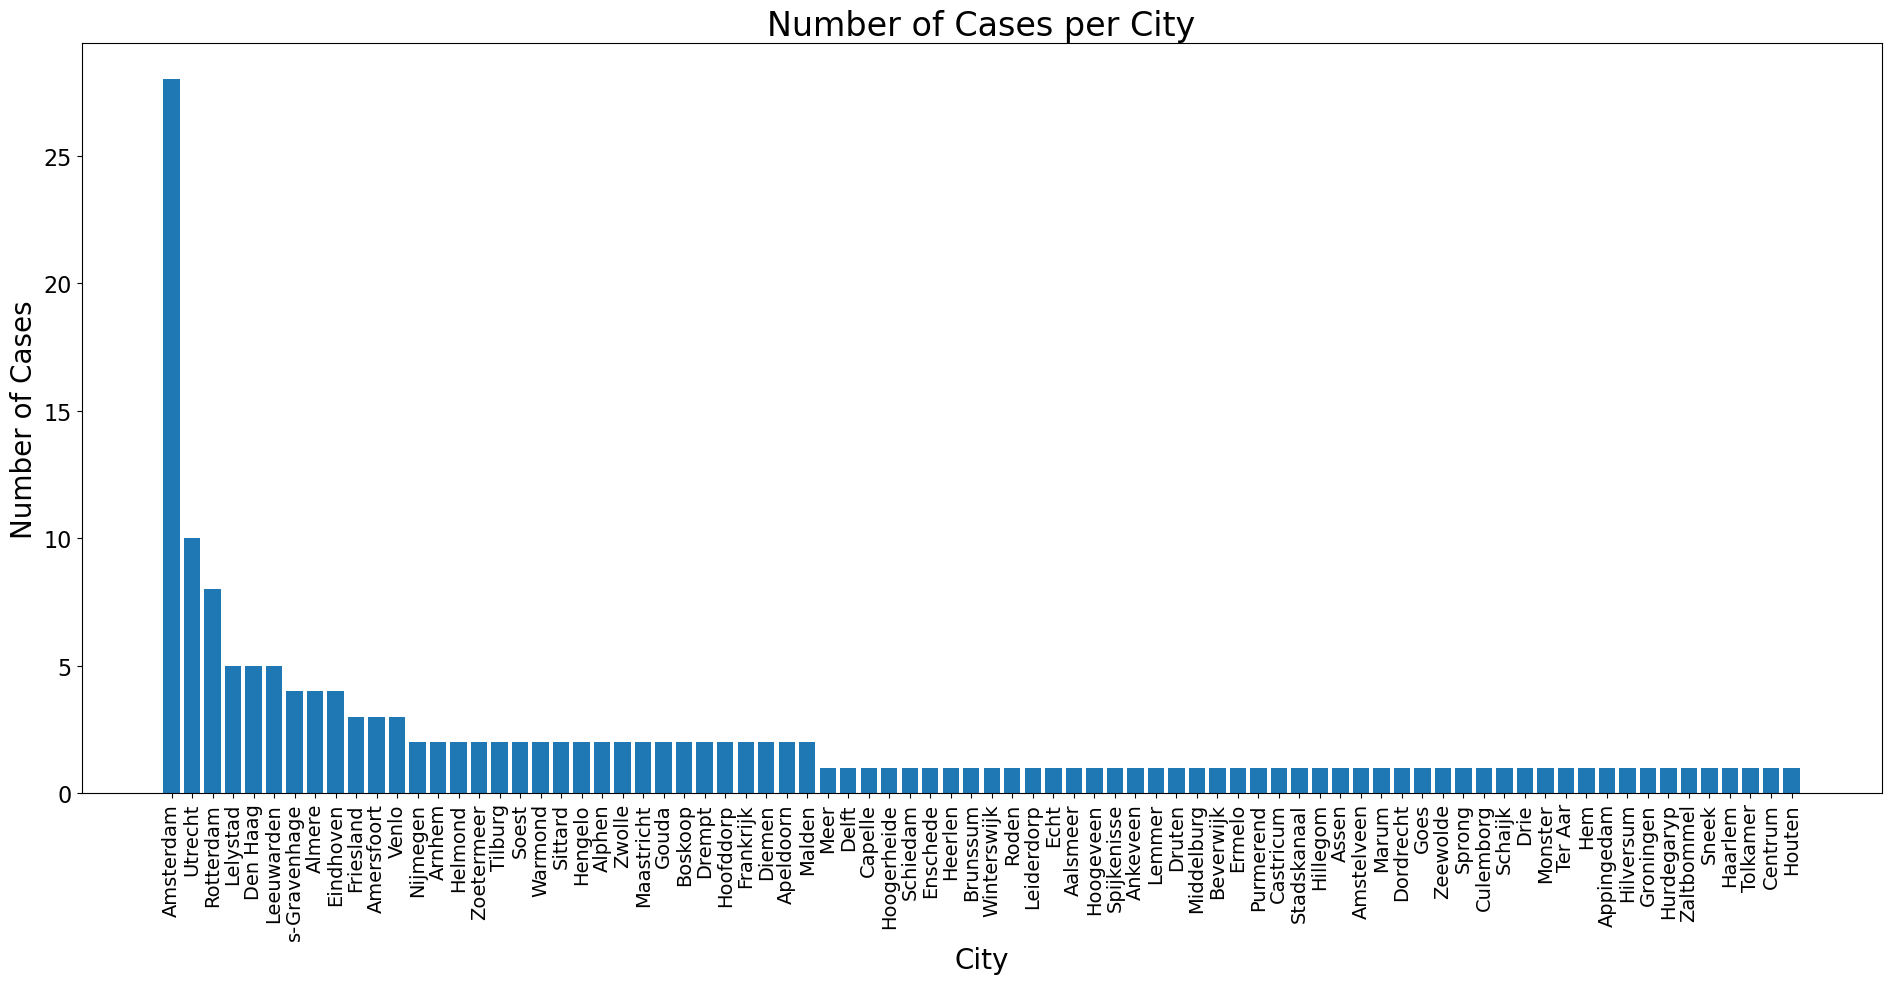

In [11]:
# Count the number of cases per city
city_counts = final_df['crime_location'].value_counts()

# Plot the data as a bar chart
plt.figure(figsize=(20, 10))
plt.bar(city_counts.index, city_counts.values)
plt.xlabel('City', fontsize=20)
plt.ylabel('Number of Cases', fontsize=20)
plt.title('Number of Cases per City', fontsize=24)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=16)
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.15, top=0.9)
plt.savefig(location_charts+'cases_per_city.jpg', dpi=300)
plt.show()


In [12]:
import folium
from geopy.geocoders import Nominatim
import seaborn as sns

geolocator = Nominatim(user_agent="geoapiExercises")

city_latitude = {}
city_longitude = {}

for city in city_counts.index:
    location = geolocator.geocode(city)
    city_latitude[city] = location.latitude
    city_longitude[city] = location.longitude

# Create a map centered on the Netherlands
nl_map = folium.Map(location=[52.3780, 4.8909], zoom_start=8)

# Add markers for each city
for city in city_counts.index:
    folium.Marker(
        location=[city_latitude[city], city_longitude[city]],
        icon=folium.Icon(color='red',icon='info-sign')
    ).add_child(folium.Popup(f"{city}: {city_counts[city]} cases")).add_to(nl_map)

# Display the map
nl_map

<Figure size 1000x500 with 0 Axes>

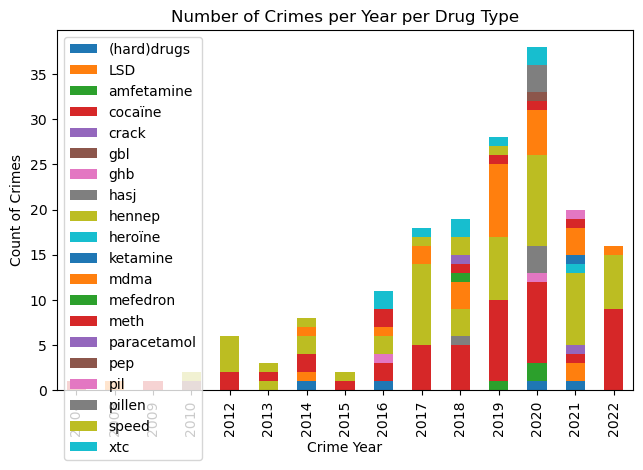

In [13]:

drug_type_year_count = final_df.groupby(["crime_year", "drug_type"]).size().reset_index(name="count")

plt.figure(figsize=(10,5))
drug_type_year_count.pivot(index='crime_year', columns='drug_type', values='count').plot(kind='bar', stacked=True)
plt.xlabel("Crime Year")
plt.ylabel("Count of Crimes")
plt.title("Number of Crimes per Year per Drug Type")
plt.legend(loc='upper left')
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.15, top=0.9)
plt.savefig(location_charts+'crime_year_drug_type.jpg', dpi=300)
plt.show()